# Проект: классификация

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [69]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [70]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [71]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [72]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(',00','')
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance']= df['balance'].astype('float64')
print('Среднее по столбцу баланс:', round(df['balance'].mean(), 3))

Среднее по столбцу баланс: 1529.129


### Задание 4

In [73]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее по столбцу баланс:', round(df['balance'].mean(), 3))

Среднее по столбцу баланс: 1526.936


### Задание 5

In [74]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)
print(round(df[(df['education']=='secondary') & (df['job']=='management')]['balance'].mean(),3))

1598.883


### Задание 6

In [75]:
df.shape

(11162, 17)

In [76]:
# удалите все выбросы для признака balance
# ваш код
# функция для определения выбросов:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, upper_bound, lower_bound

outliers, df, upper_bound, lower_bound= outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')
print('Верхняя граница:', upper_bound, 'Нижняя граница:', lower_bound)

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница: 4063.0 Нижняя граница: -2241.0


## Часть 2:  Разведывательный анализ

### Задание 1

In [77]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


4681

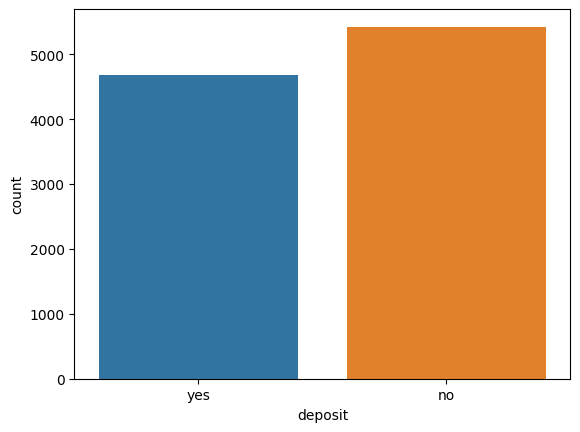

In [78]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
sns.countplot(data=df, x='deposit');

df[df['deposit'] == 'yes'].shape[0]

### Задания 2 и 3

In [79]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [80]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


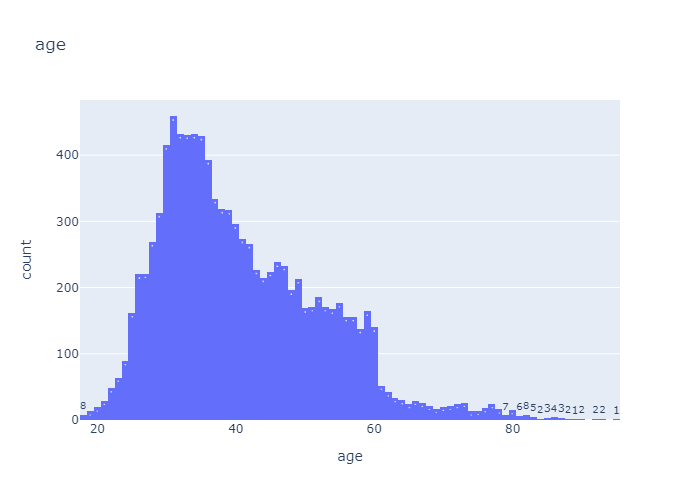

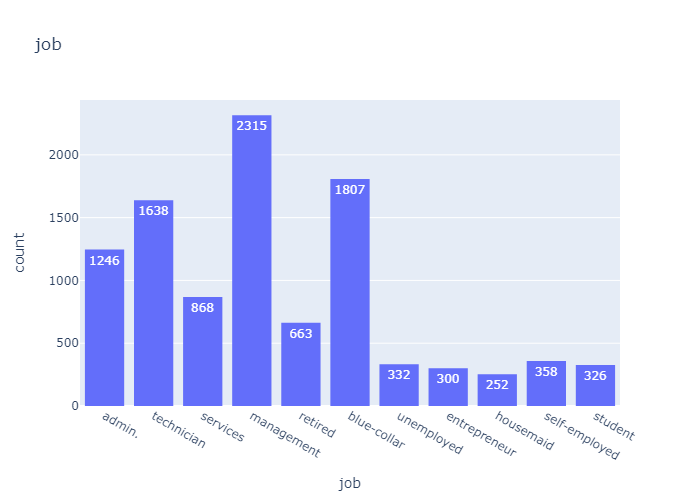

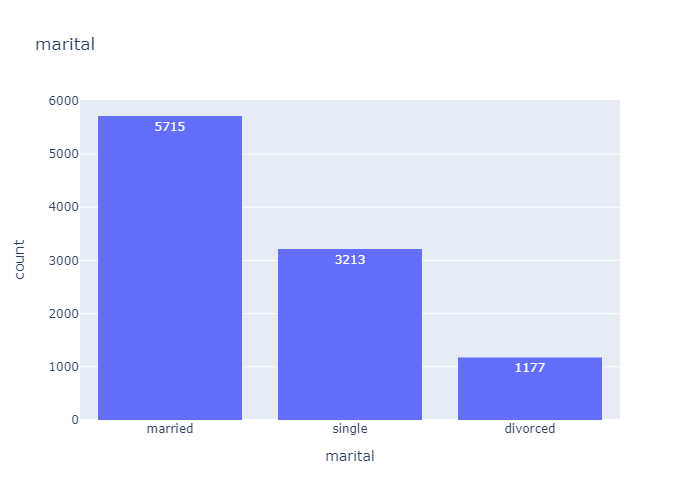

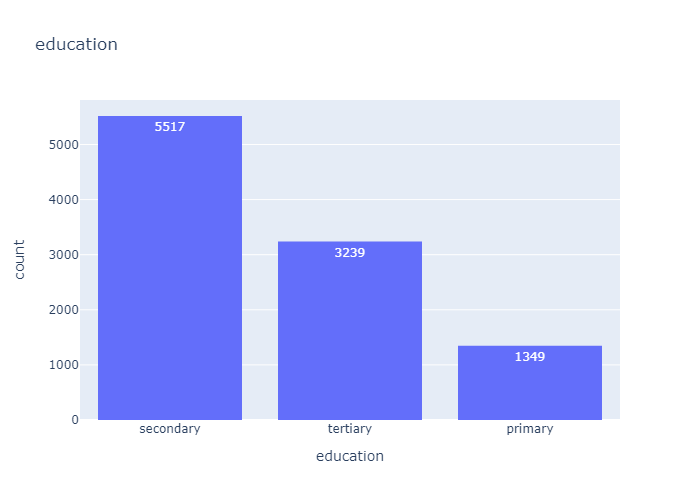

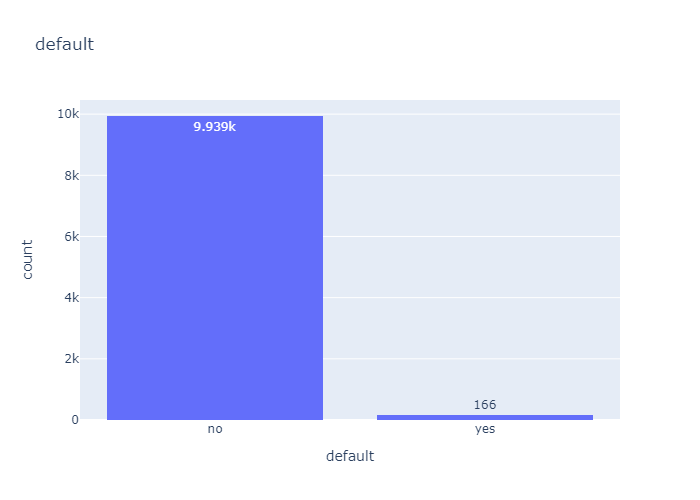

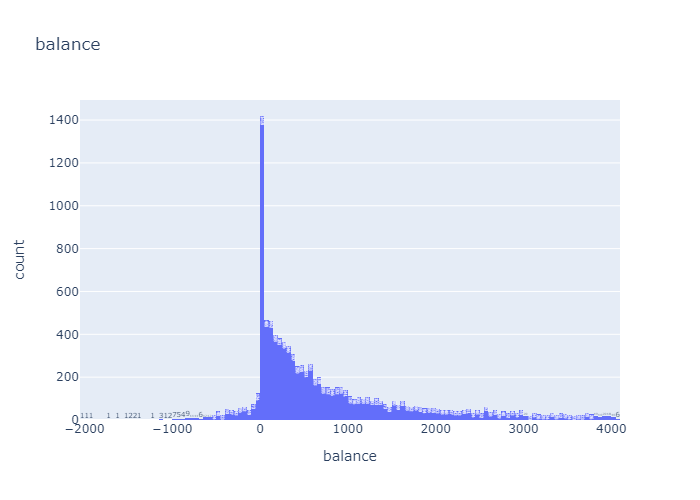

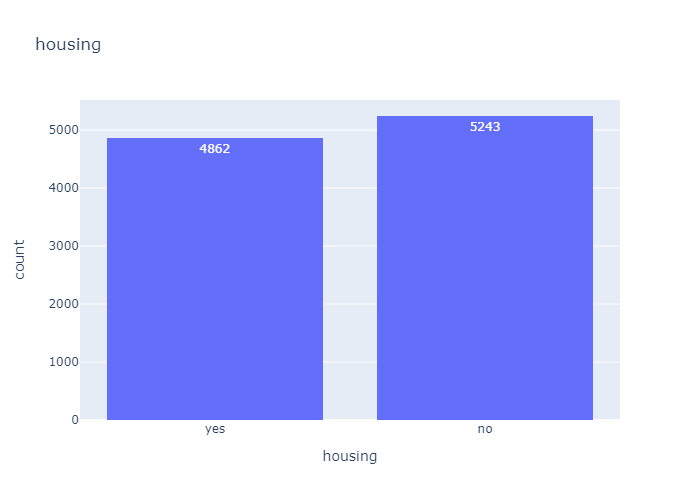

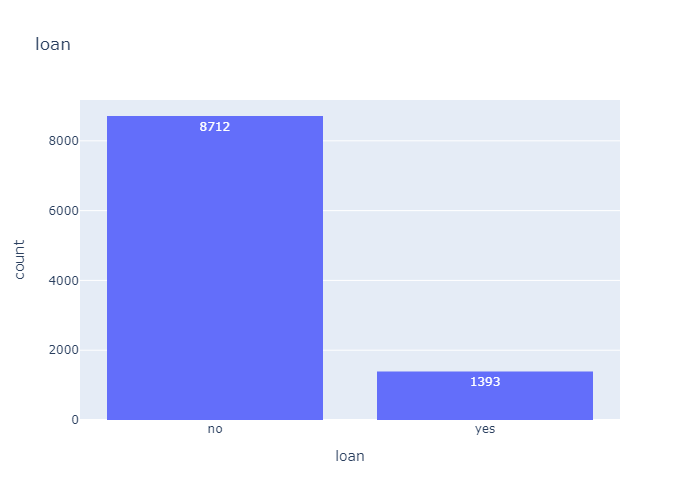

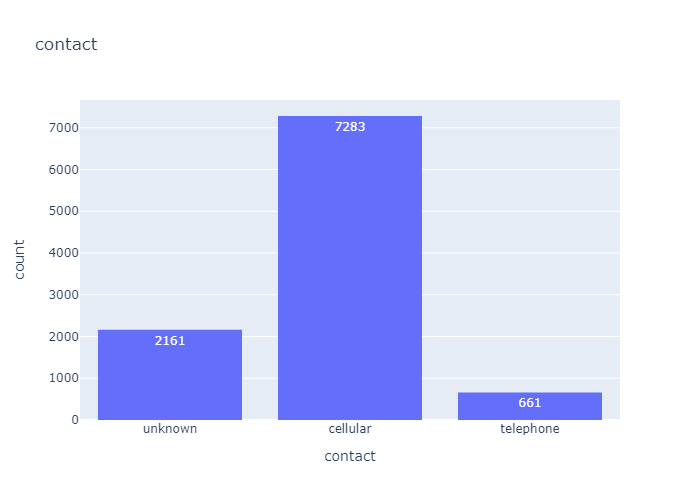

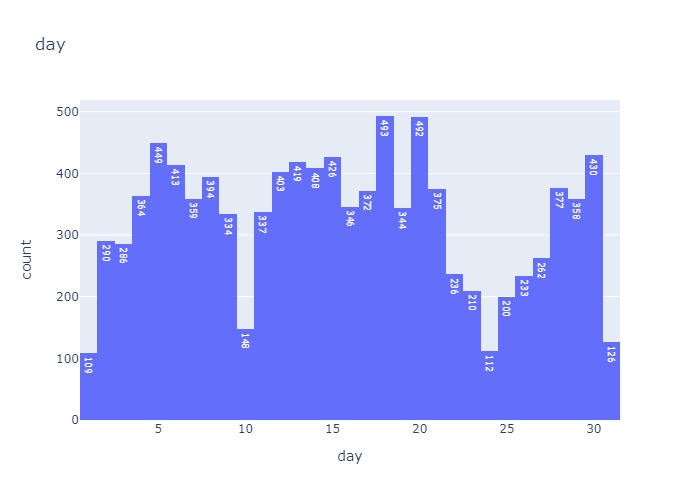

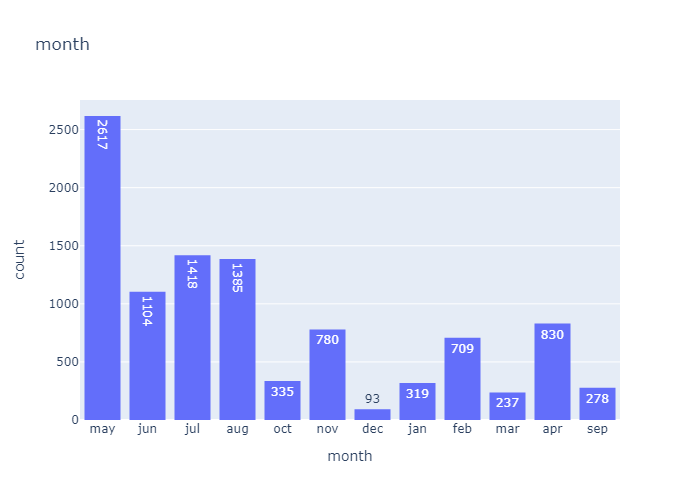

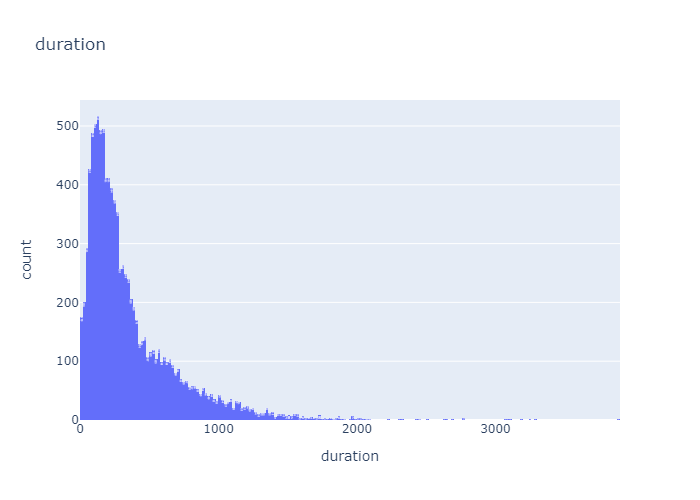

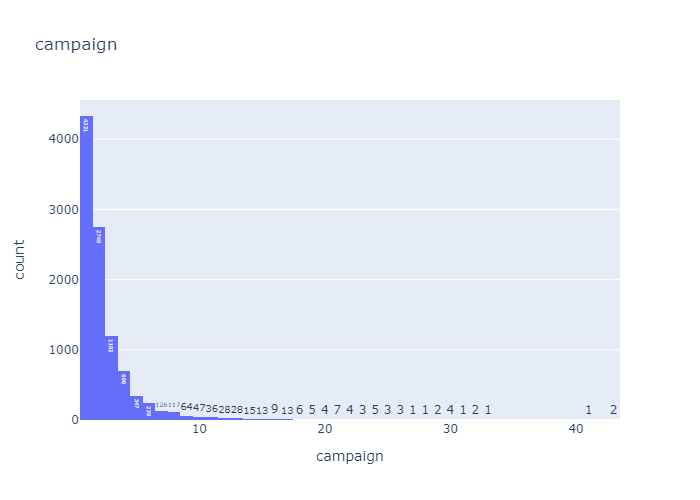

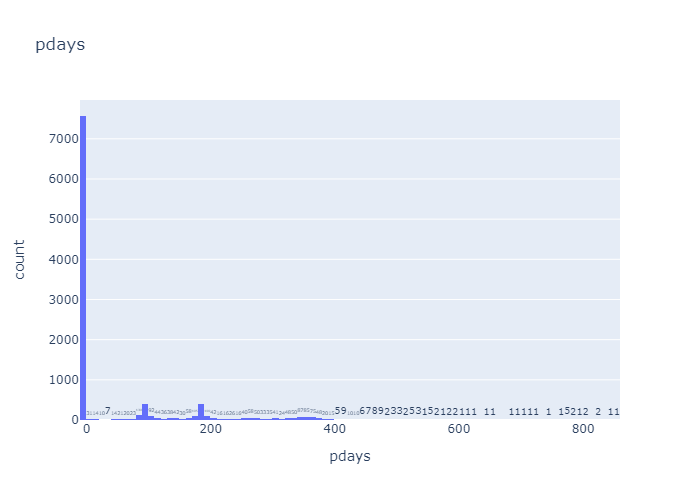

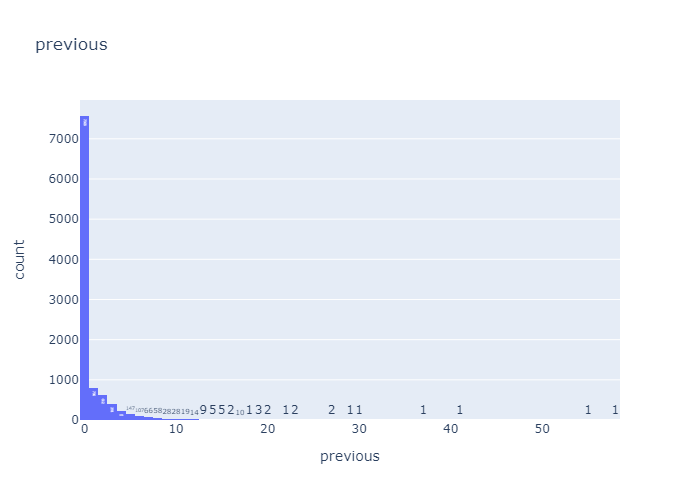

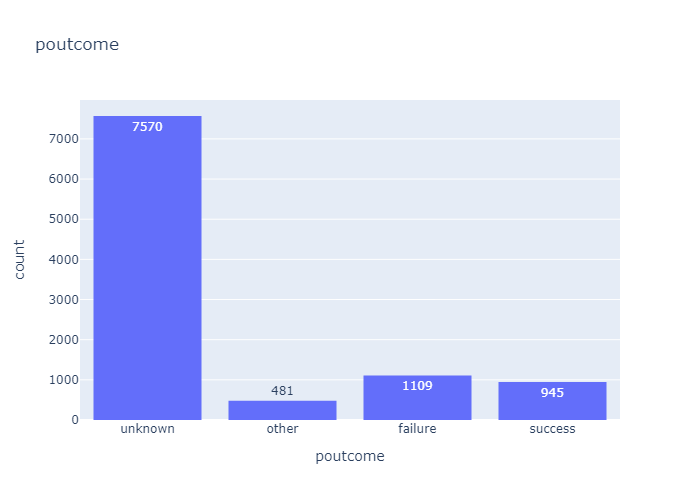

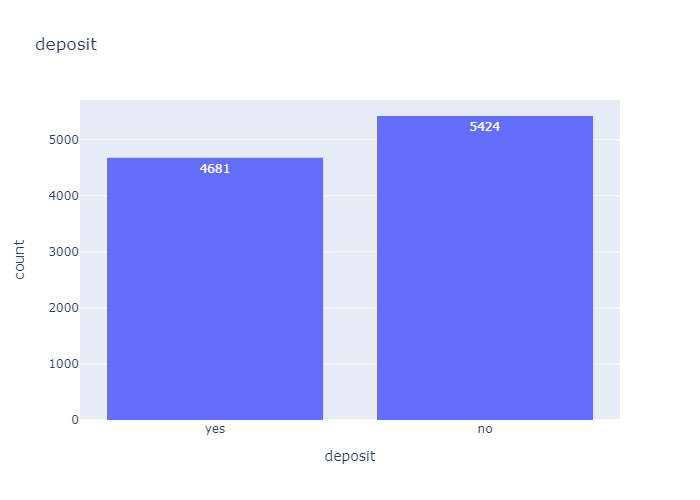

In [81]:
for i in list(df.columns):
    fig = px.histogram(df, x=i, title=i, text_auto=True)
    fig.show('png')

### Задание 6

In [82]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [83]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

In [84]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
percent_failure = round((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

В may месяце больше всего отказывались от открытия депозита.


### Задание 8

In [85]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

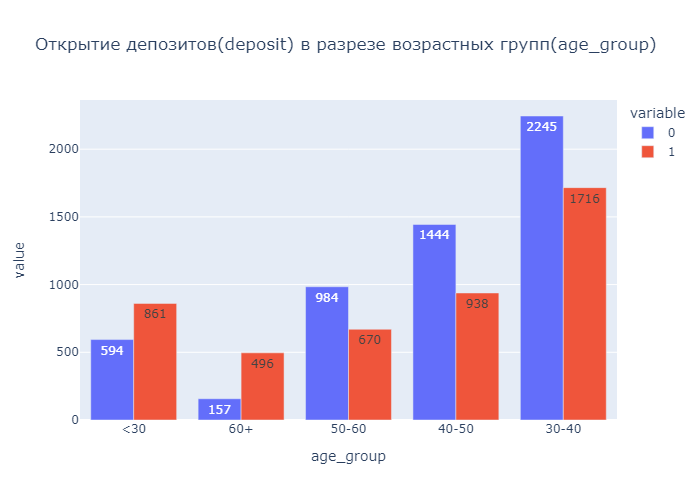

In [86]:
fig = px.bar(df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(age_group)')
fig.show('png')

### Задания 9 и 10

In [87]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df.groupby('marital')['deposit'].value_counts()

marital   deposit
divorced  0           624
          1           553
married   0          3303
          1          2412
single    1          1716
          0          1497
Name: deposit, dtype: int64

In [88]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df.groupby('education')['deposit'].value_counts()

education  deposit
primary    0           832
           1           517
secondary  0          3066
           1          2451
tertiary   1          1713
           0          1526
Name: deposit, dtype: int64

In [89]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df.groupby('job')['deposit'].value_counts()

job            deposit
admin.         0           672
               1           574
blue-collar    0          1155
               1           652
entrepreneur   0           189
               1           111
housemaid      0           153
               1            99
management     0          1180
               1          1135
retired        1           432
               0           231
self-employed  0           197
               1           161
services       0           523
               1           345
student        1           245
               0            81
technician     0           900
               1           738
unemployed     1           189
               0           143
Name: deposit, dtype: int64

### Задание 11

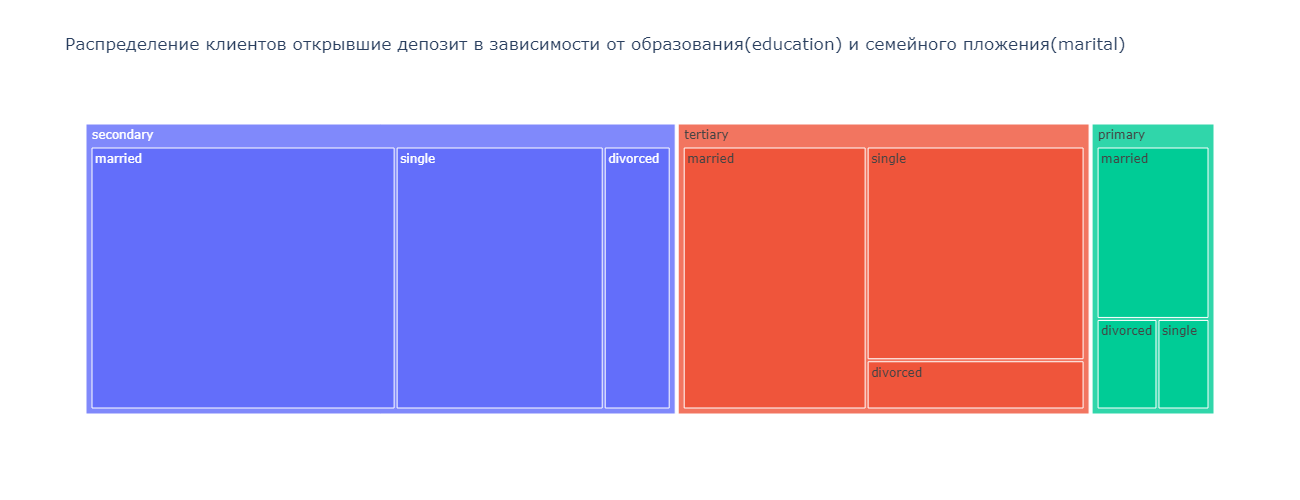

In [90]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
round(df.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1]/df.groupby(['education', 'marital'])['deposit'].count() * 100)

p1 = df[df['deposit']==1]
p1 = pd.DataFrame(p1.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p1, #DataFrame
    path=[p1.index.get_level_values(0), p1.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=1, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов открывшие депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')


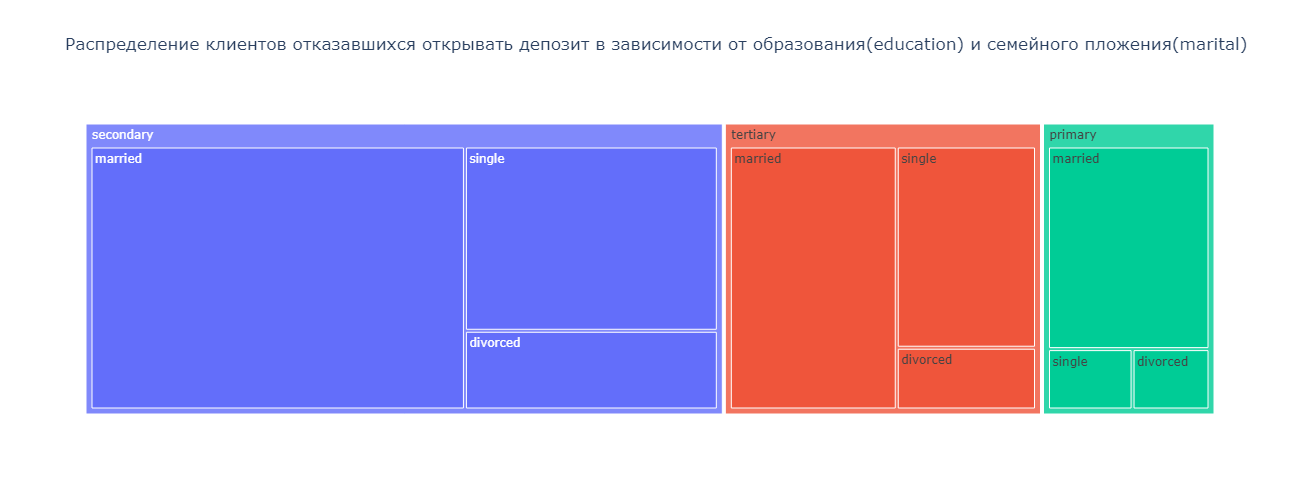

In [91]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто отказался открыть депозит)
p2 = df[df['deposit']==0]
p2 = pd.DataFrame(p2.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p2, #DataFrame
    path=[p2.index.get_level_values(0), p2.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=0, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов отказавшихся открывать депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')


## Часть 3: преобразование данных

### Задание 1

In [92]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education_cod'] = data_educ

In [93]:
# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age

In [94]:
df['education_cod'].sum()

11995

### Задания 2 и 3

In [95]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'].describe()
df['default'] = df['default'].apply(lambda x:int(1) if x == 'yes' else int(0))
df['housing'] = df['housing'].apply(lambda x:int(1) if x == 'yes' else int(0))
df['loan'] = df['loan'].apply(lambda x:int(1) if x == 'yes' else int(0))



In [96]:
print(round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

0.635


### Задание 4

In [97]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], prefix=['job', 'marital', 'contact', 'month', 'poutcome'])



In [98]:
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,secondary,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,secondary,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,secondary,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,secondary,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,tertiary,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


In [99]:
df.shape[1]

47

### Задания 5 и 6

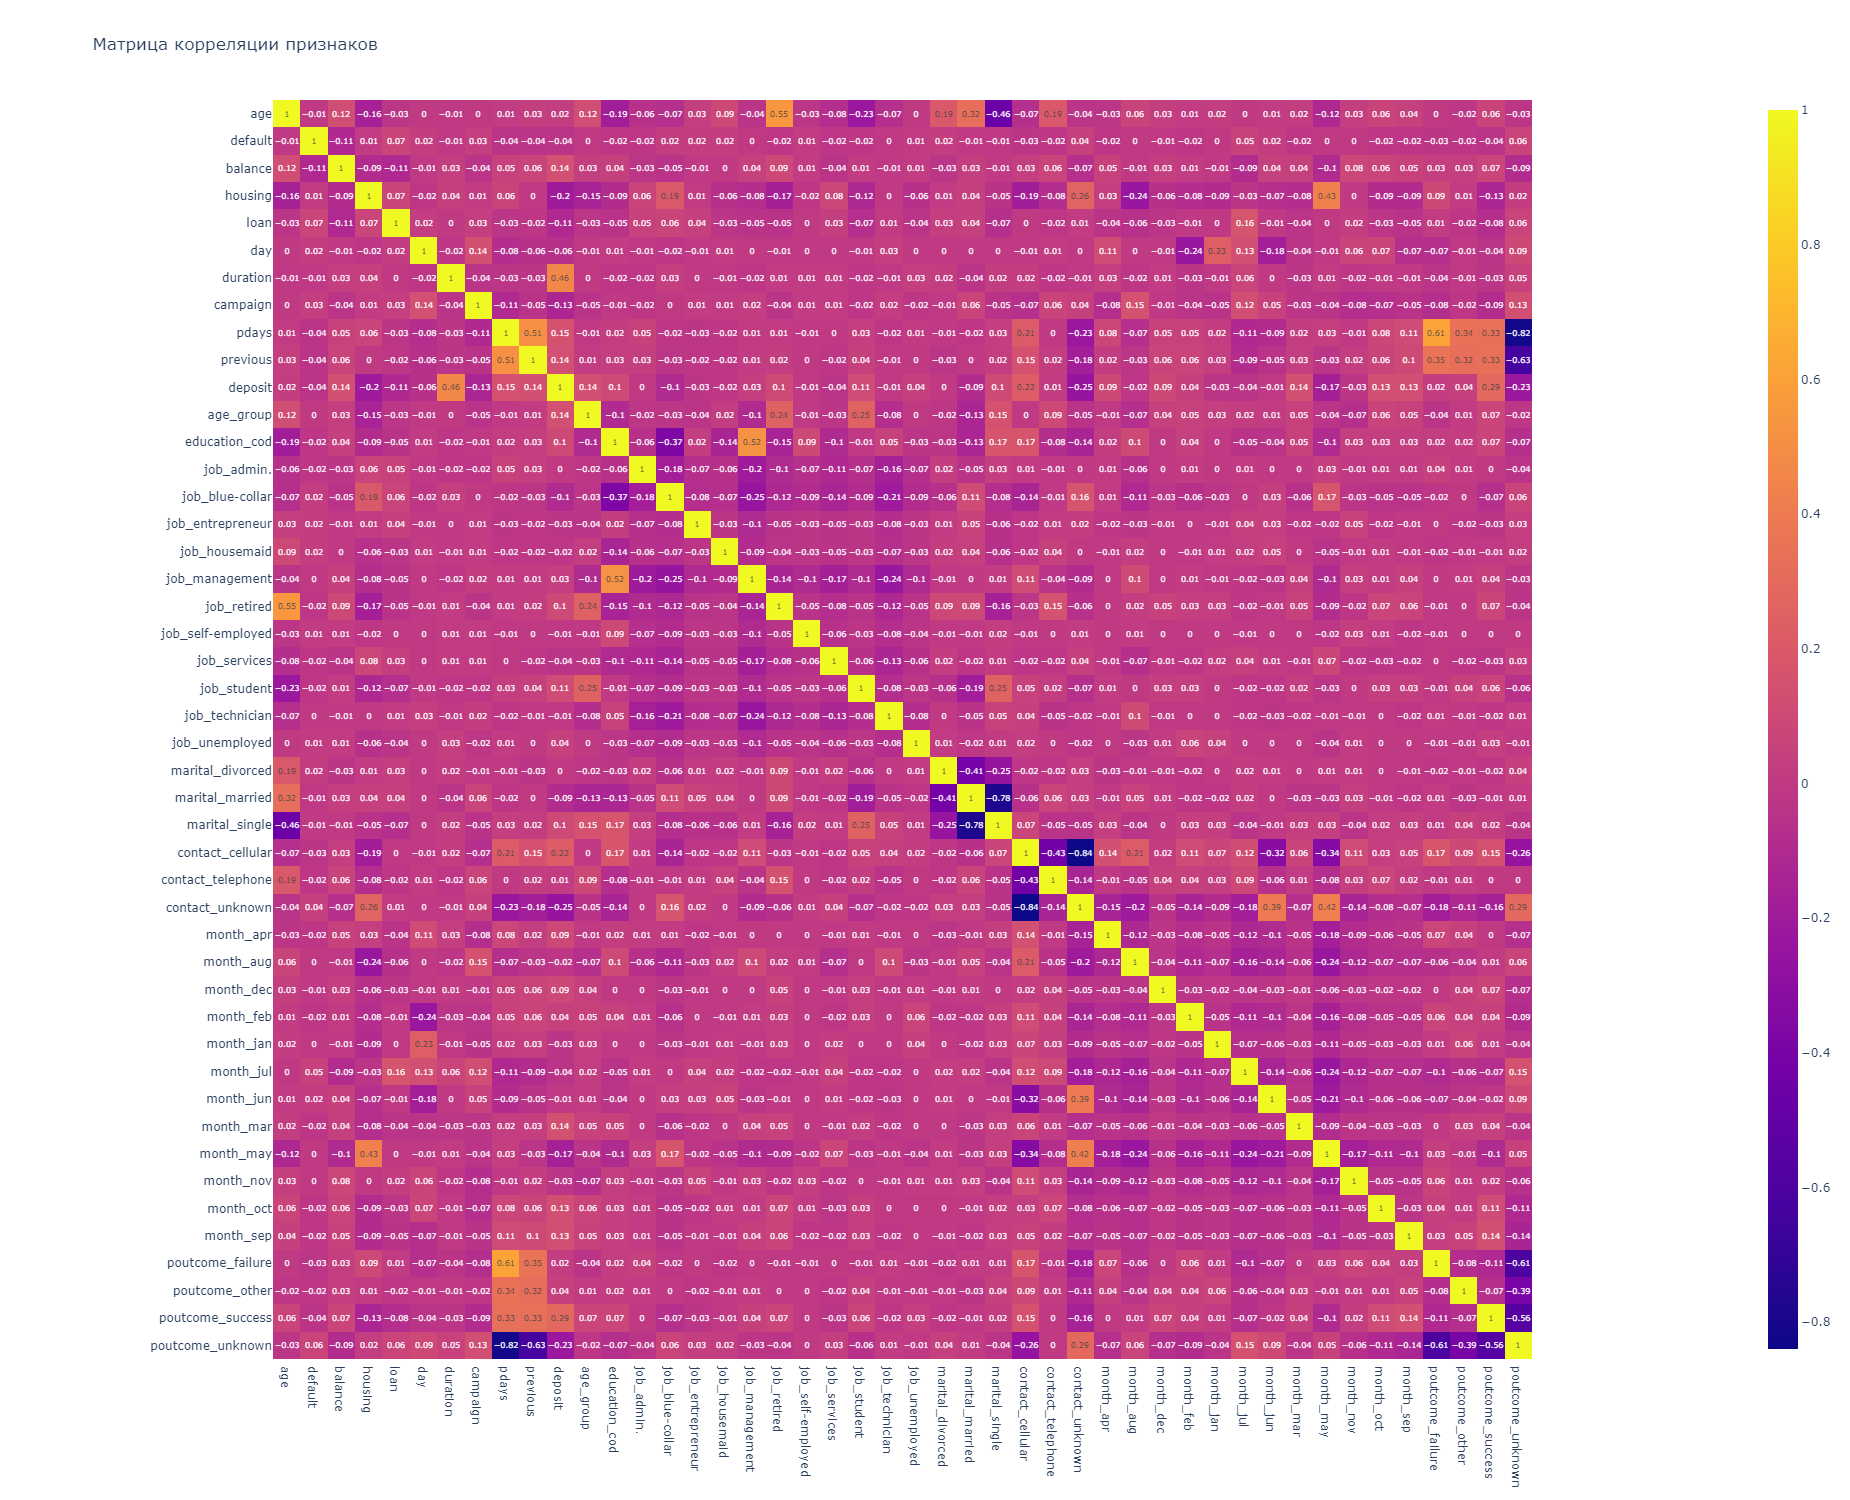

In [100]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show('png')

In [101]:
df = df.drop(['education'], axis=1)

### Задания 7 и 8

In [102]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [103]:
# рассчитайте необходимые показатели
X_test.shape
y_test.mean()

0.46326836581709147

### Задание 9

In [104]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [105]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[selector_col])
X_train_scaled = scaler.transform(X_train[selector_col])
X_test_scaled = scaler.transform(X_test[selector_col])
X_test_scaled[ :, 0].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [106]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_test_pred = log_model.predict(X_test_scaled)
y_train_pred = log_model.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.accuracy_score(y_test, y_test_pred)}')
print(f'Мерики на тренировочных даннных\n {metrics.accuracy_score(y_train, y_train_pred)}')


Мерики на тестовых даннных
 0.8047976011994002
Мерики на тренировочных даннных
 0.8243722304283604


### Задания 2,3,4

In [107]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scaled, y_train)
y_test_pred = tree_model.predict(X_test_scaled)
y_train_pred = tree_model.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770



### Задание 5

In [108]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scaled, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scaled)
y_train_pred = grid_search.predict(X_train_scaled)
print(f'Мерики на тестовых даннных\n {metrics.f1_score(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.f1_score(y_train, y_train_pred)}')

exception calling callback for <Future at 0x1d0ededf6a0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "e:\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "e:\anaconda3\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute '_FuncWrapper' on <module 'sklearn.utils.fixes' from 'e:\\anaconda3\\lib\\site-packages\\sklearn\\utils\\fixes.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "e:\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "e:\anaconda3\lib\site-packages\joblib\parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "e:\anaconda3\lib\s

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scaled, y_train)
y_train_pred = forest_model.predict(X_train_scaled)
y_test_pred = forest_model.predict(X_test_scaled)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'recall\n {metrics.recall_score(y_test, y_test_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

recall
 0.8349514563106796


### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    learning_rate = 0.05,
    min_samples_leaf = 5,
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test_scaled)

# Оцениваем качество по метрике MSE
print(f'Мерики на тестовых даннных\n {metrics.f1_score(y_test, gb_pred)}')

Мерики на тестовых даннных
 0.8167672276913305


### Задание 4

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('lr', linear_model.LogisticRegression(
        max_iter = 1000, 
        random_state=42, 
        solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
    )),
    ('gb', ensemble.GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    learning_rate = 0.05,
    min_samples_leaf = 5,
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
    ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(max_iter = 1000, random_state=42, solver='sag')
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по f1 для стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')

Качество предсказания по f1 для стекинга 0.81


### Задание 5

In [113]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
ooo = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(ooo.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(ooo.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

AttributeError: 'GradientBoostingClassifier' object has no attribute 'feature_names_in_'

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = forest_model
  
  # обучаем модель 
  model.fit(X_train_scaled, y_train)
  y_train_pred = model.predict(X_train_scaled)
  score = metrics.f1_score(y_train, y_train_pred)

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2023-04-19 12:39:55,198] A new study created in memory with name: RandomForestClassifier
[I 2023-04-19 12:39:57,351] Trial 0 finished with value: 0.8483703353802551 and parameters: {'n_estimators': 127, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8483703353802551.
[I 2023-04-19 12:39:59,523] Trial 1 finished with value: 0.8483703353802551 and parameters: {'n_estimators': 152, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8483703353802551.
[I 2023-04-19 12:40:01,803] Trial 2 finished with value: 0.8483703353802551 and parameters: {'n_estimators': 124, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8483703353802551.
[I 2023-04-19 12:40:03,579] Trial 3 finished with value: 0.8483703353802551 and parameters: {'n_estimators': 135, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8483703353802551.
[I 2023-04-19 12:40:06,062] Trial 4 finished with value: 0.8483703353802551 and parameters: {'

Наилучшие значения гиперпараметров {'n_estimators': 127, 'max_depth': 22, 'min_samples_leaf': 7}
F1 for test data=0.82
Accuracy for test data=0.83


# Выводы:

Для решения задачи классификации в данном кейсе хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna. 

В ходе исследования выделили три наиболее важных признака(далее признаки перечислены по мере убывания важности):
- **duration (продолжительность контакта в секундах)** -  оптимальная продолжительность контакта находится в диапазоне - от 240 до 340 секунд.
- **poutcome_success(результат прошлой маркетинговой кампании - success(успех, согласие))**
- **contact_unknown(тип контакта с клиентом- unknown(неизвестный))**

Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д. 

Вторичны факторы внутренние для конкретного клиента:
- **job_student**, **job_retired**(сфера занятости) - целевая аудитория это студенты и клиенты находящиеся на пенсии
- **age_group**(возрастная группа) - потенциальные группы - младше 31 и старше 60
- **marital** (семейное положение) - клиенты не состоящие в браке
- **month**(месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

и т.д., которые тоже влияют на решение клиента в меньшей степени, но необходимо учитывать при планировании будущей маркетинговой кампании.

Также стоит упомянуть о лояльности клиентах - как показали исследования клиентов ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и poutcome(результат прошлой маркетинговой кампании).

In [3]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
